# Projecting parameter uncertainty under future climate change

Import modules

In [1]:
import numpy as np
from scipy.io import netcdf as nc
import matplotlib.pyplot as plt

Parameter information

In [2]:
in_params = ['medlynslope','dleaf','kmax','fff','dint','baseflow_scalar']
npar = len(in_params)
ndim = npar

Select output variables

In [3]:
var = ["GPP", "LHF"]
nvar = len(var)

Read posterior distribution from MCMC and plot

(200, 6)


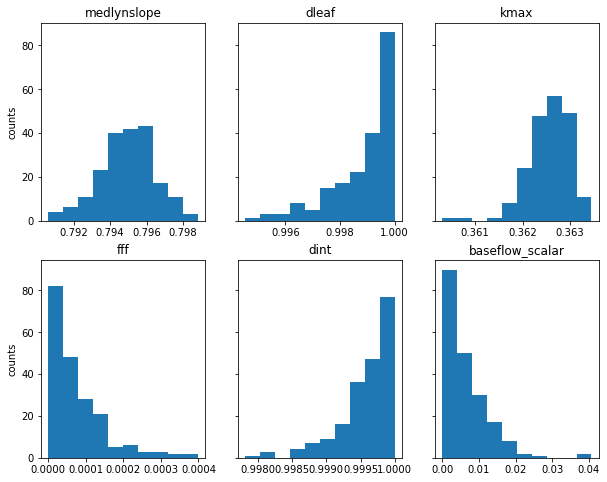

In [4]:
posterior = np.load("MCMC_posteriors/MCMC_last_sample_1e4epochs_v7.npy")
print(posterior.shape)
nsamples = posterior.shape[0]
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey='row', figsize=(10, 8))
labels = in_params
axes = axes.flatten()
for i in range(ndim):
    ax = axes[i]
    ax.hist(posterior[:,i])
    ax.set_title(labels[i])

axes[0].set_ylabel("counts")
axes[3].set_ylabel("counts");

Supress tensorflow warnings

In [6]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib

ML modules

In [7]:
import keras.backend as K
from keras.models import load_model

Using TensorFlow backend.


Define error metric for trained NN

In [8]:
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)

Load previously trained model

In [9]:
NN_models = [load_model("emulators/NN_"+v+"diff_finalize_multi-dim.h5", 
    custom_objects={'mean_sq_err' :mean_sq_err}) for v in var]

W1022 13:53:05.494115 140625750320896 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1022 13:53:05.996975 140625750320896 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1022 13:53:06.110902 140625750320896 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1022 13:53:06.111808 140625750320896 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:200: The name tf.ConfigProto 

Generate predictions from posterior distributions

In [10]:
post_preds = [NN_models[i].predict(posterior) for i,v in enumerate(var)]
post_preds[0].shape

(200, 3)

Reconstruct spatial maps using SVD of difference (future - control)

In [11]:
# see also SVD.py
f = nc.netcdf_file("outputdata/outputdata_"+var[0]+"_forSVD_100_diff.nc",'r',mmap=False)
X = f.variables[var[0]]
mask = f.variables['datamask']
d = X[:]
m = mask[:]
nens=d.shape[0]
nlat=d.shape[1]
nlon=d.shape[2]
dr = np.reshape(d,(nens,nlat*nlon))
print(dr.shape)
mr = np.reshape(m,nlat*nlon)
drm = dr[:,mr==1]
drm[drm==1.e+36] = 0
print(drm.shape)
U,s,Vh = np.linalg.svd(drm, full_matrices=False)
print(U.shape, s.shape, Vh.shape)
s_trunc = s[:3] # truncated at 3 modes - but should I be using more? only ~75% of variance explained. would require re-creating/training NNs for GPP/LHF diffs, thus re-doing optimization/MCMC to get posteriors
Vh_trunc = Vh[:3,:]

(100, 3312)
(100, 724)
(100, 100) (100,) (100, 724)


In [18]:
#reconstruction
U_preds = post_preds[0]
recon1 = np.dot(U_preds*s_trunc, Vh_trunc)
print(recon1.shape)
#smat_trunc = np.diag(s_trunc)
#recon2 = np.dot(U_preds, np.dot(smat_trunc, Vh_trunc))
#print(recon1.shape, recon2.shape)

(200, 724)


In [13]:
lats = f.variables['lat'] # 46 lats
lons = f.variables['lon'] # 72 lons
#m[0,:]
test = m==1
test.shape
#mlat = lats[m==1]

(46, 72)

In [14]:
# this doesn't work yet because reconstruction only includes land lat/lon (how to reshape globally, filling in mask?)
#recon1_latlon = np.reshape(recon1, (nsamples, nlat, nlon))
# could try starting SVD over with xarray - easier to subset land only (use np.isnan?)
# from python tutorial:
#inds = np.isnan(X) # this function can somehow be applied to reshape without nans
#Y = X.sel(inds=True, drop=True)

(array([ 1.,  1.,  5., 20., 34., 45., 46., 29., 14.,  5.]),
 array([-2.6216054e-05, -2.5792335e-05, -2.5368614e-05, -2.4944893e-05,
        -2.4521174e-05, -2.4097455e-05, -2.3673734e-05, -2.3250013e-05,
        -2.2826294e-05, -2.2402575e-05, -2.1978854e-05], dtype=float32),
 <a list of 10 Patch objects>)

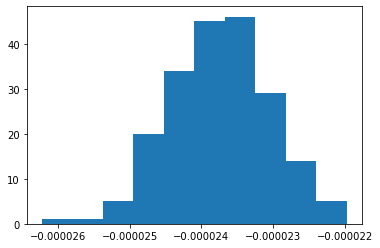

In [15]:
#plt.contourf(recon1)
plt.hist(recon1[:,0])

In [19]:
#plt.hist(recon2[:,0])

In [20]:
#diff = recon2 - recon1
#plt.hist(diff[:,0]) # sufficiently small